In [35]:
# Это просто чтобы на проекторе всё было красиво.
# Не обращайте внимания

from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 1.8em;
line-height:1.0em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.4em;
line-height:1.3em;
padding-left:2em;
padding-right:2em;
}
</style>
""")

In [10]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, KFold

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, Lasso, RidgeClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.naive_bayes import MultinomialNB
from scipy import sparse
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

from nltk.stem.porter import PorterStemmer

%matplotlib inline

In [5]:
train, test = train_test_split(df)

In [6]:
df = pd.read_csv('data/tagged_plots_movielens.csv')
train['plot'] = train['plot'].fillna('Nan')
test['plot'] = test['plot'].fillna('Nan')
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 4 columns):
Unnamed: 0    2448 non-null int64
movieId       2448 non-null int64
plot          2427 non-null object
tag           2448 non-null object
dtypes: int64(2), object(2)
memory usage: 76.6+ KB
None


,Unnamed: 0,movieId,plot,tag
0,0,1,A little boy named Andy loves to be in his roo...,animation
1,1,2,When two kids find and play a magical board ga...,fantasy
2,2,3,Things don't seem to change much in Wabasha Co...,comedy
3,3,6,Hunters and their prey--Neil and his professio...,action
4,4,7,An ugly duckling having undergone a remarkable...,romance
5,5,9,Some terrorists kidnap the Vice President of t...,action
6,6,10,James Bond teams up with the lone survivor of ...,action
7,7,15,"Morgan Adams and her slave, William Shaw, are ...",action
8,8,17,"When Mr. Dashwood dies, he must leave the bulk...",romance
9,9,18,This movie features the collaborative director...,comedy


In [50]:
tmp = df.sample()
print(tmp['tag'].values[0])
tmp['plot'].values[0]

fantasy


"Maj. Pete Sandidge is a very able pilot who seems to have a streak of luck as far as flying goes. World War II is raging and Pete has come out of it pretty so far. He even has a beautiful girlfriend Dorinda Durston, herself a qualified pilot who ferries aircraft to different bases. When Pete is killed however, he finds himself in heaven and learns that every pilot has a guardian angel. He returns to Earth where, unseen by anyone, he coaches a pilot-in-training Ted Randall. Ted is a pretty good kid and is coming along nicely but when he's shipped to New Guinea he runs into Dorinda who has remained faithful to her lost love. As Ted pursues her, Pete will have to decide what he wants to do about it."

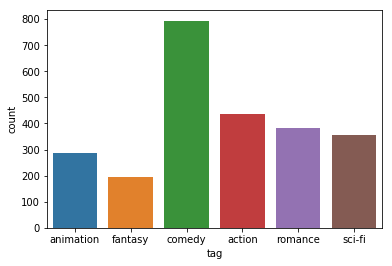

In [7]:
sns.countplot(df['tag'])

# CountVectorizer

Для начала попробуем в лоб запустить мешок слов без предобработки текста. Это будет наш бейзлайн.

In [16]:
my_tags = ['sci-fi' , 'action', 'comedy', 'fantasy', 'animation', 'romance']
def examine(clf, X_train, X_test, y_train, y_test, scoring='accuracy'):
    clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), xticklabels=my_tags, yticklabels=my_tags, annot=True, fmt="d",cmap=plt.cm.Blues)
    plt.show()
    print('%s1 : %s2' % (clf.__class__.__name__, scores))
    return {'score': scores, 'clf': clf.__class__.__name__}

In [87]:
def most_influential_words(clf, vectorizer, genre_name='action', num_words=10):
    genre_name = np.argwhere(clf.classes_== genre_name)[0][0]
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(clf.coef_[genre_name]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]

In [57]:
def classifiers():
    return [
        DummyClassifier(random_state=42), 
    #     Lasso(random_state=42), 
        RidgeClassifier(random_state=42),
        SGDClassifier(random_state=42),
        AdaBoostClassifier(random_state=42),
        GradientBoostingClassifier(n_estimators=30, random_state=42),
        RandomForestClassifier(n_estimators=30, random_state=42),
        KNeighborsClassifier(n_neighbors=5),
        KNeighborsClassifier(n_neighbors=3),
        LogisticRegression(n_jobs=1, C=1e5)
    ]

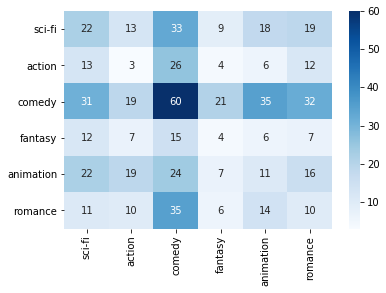

DummyClassifier1 : 0.179738562091503272


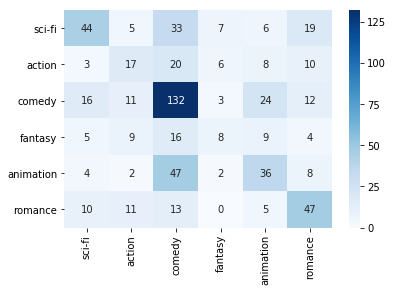

RidgeClassifier1 : 0.464052287581699362


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


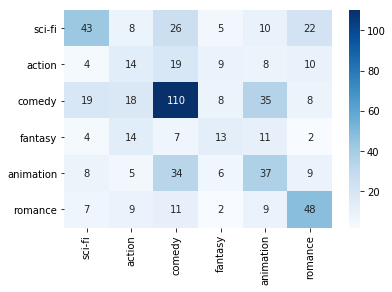

SGDClassifier1 : 0.433006535947712432


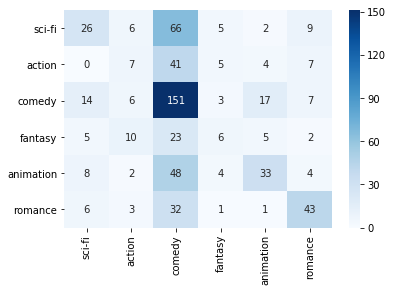

AdaBoostClassifier1 : 0.4346405228758172


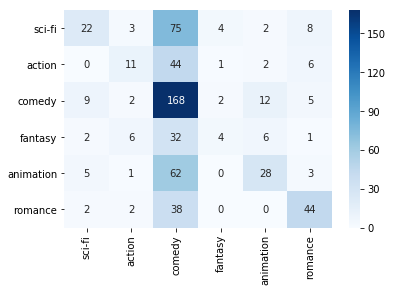

GradientBoostingClassifier1 : 0.45261437908496732


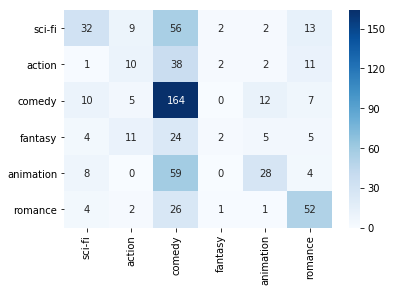

RandomForestClassifier1 : 0.470588235294117642


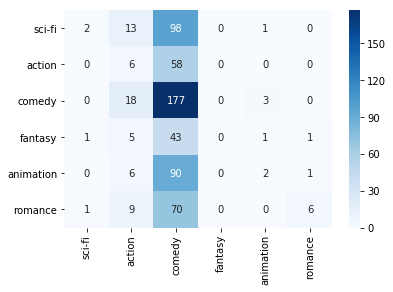

KNeighborsClassifier1 : 0.3153594771241832


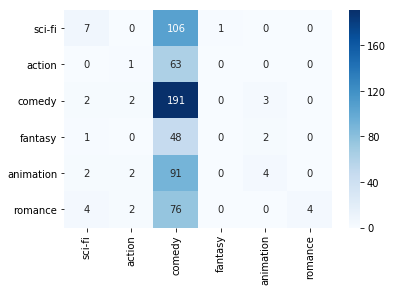

KNeighborsClassifier1 : 0.33823529411764712


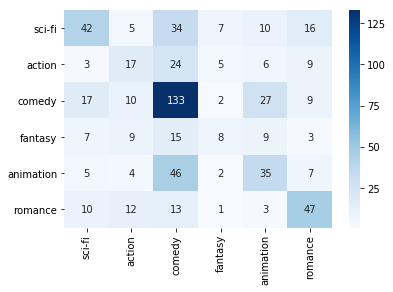

LogisticRegression1 : 0.460784313725490172


In [60]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
bag_of_words_train = cv.fit_transform(train['plot'])
bag_of_words_test = cv.transform(test['plot'])

results = [examine(clf, bag_of_words_train, bag_of_words_test, train['tag'], test['tag']) for clf in classifiers()]

In [32]:
def print_results(results):
    res_ordered = sorted(results, key = lambda x: x['score'])
    for res in res_ordered:
        print("{}: {}".format(res['clf'], res['score']))

In [61]:
sorted(results, key = lambda x: x['score'])

[{'clf': 'DummyClassifier', 'score': 0.17973856209150327},
 {'clf': 'KNeighborsClassifier', 'score': 0.315359477124183},
 {'clf': 'KNeighborsClassifier', 'score': 0.3382352941176471},
 {'clf': 'SGDClassifier', 'score': 0.43300653594771243},
 {'clf': 'AdaBoostClassifier', 'score': 0.434640522875817},
 {'clf': 'GradientBoostingClassifier', 'score': 0.4526143790849673},
 {'clf': 'LogisticRegression', 'score': 0.46078431372549017},
 {'clf': 'RidgeClassifier', 'score': 0.46405228758169936},
 {'clf': 'RandomForestClassifier', 'score': 0.47058823529411764}]

In [67]:
clf = RidgeClassifier(random_state=42)
clf.fit(bag_of_words_train, train['tag'])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=42, solver='auto',
        tol=0.001)

In [91]:
clf.classes_

array(['action', 'animation', 'comedy', 'fantasy', 'romance', 'sci-fi'],
      dtype='<U9')

In [92]:
most_influential_words(clf, cv, genre_name='action', num_words=10)

['assassin',
 'corruption',
 'pandemic',
 'operatives',
 'terrorists',
 'sadistic',
 'army',
 'track',
 'era',
 'cia']

In [93]:
most_influential_words(clf, cv, genre_name='sci-fi', num_words=10)

['future',
 'futuristic',
 'space',
 'engineer',
 'spaceship',
 'innocent',
 'survivors',
 'doomed',
 'alien',
 'investigates']

Лучшие модели дают качество 0.47~0.46.

# Лемматизация и удаление стоп слов

`PorterStemmer` - приводит слова к нормальной форме, например `is` -> `be`, `trees` -> `tree`.
`word_tokenize` - разбивает предложение на слова.  
`stopwords` -  убирает стоп слова английскомого алфавита (предлоги, местоимения и прочее)

In [28]:
", ".join(stopwords.words('english'))

'i, me, my, myself, we, our, ours, ourselves, you, your, yours, yourself, yourselves, he, him, his, himself, she, her, hers, herself, it, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, should, now, d, ll, m, o, re, ve, y, ain, aren, couldn, didn, doesn, hadn, hasn, haven, isn, ma, mightn, mustn, needn, shan, shouldn, wasn, weren, won, wouldn'

In [94]:
from nltk.corpus import stopwords

stemmer = PorterStemmer()
def tokenize_text(text):
    tokens = []
    word_tokenize = nltk.word_tokenize(text, language='english')
    for word in word_tokenize:
        if len(word) >= 2 and word not in stopwords.words('english'):
            tokens.append(stemmer.stem(word.lower()))
    return tokens

In [96]:
cv = CountVectorizer(tokenizer=tokenize_text)
bag_of_words_train = cv.fit_transform(train['plot'])
bag_of_words_test = cv.transform(test['plot'])

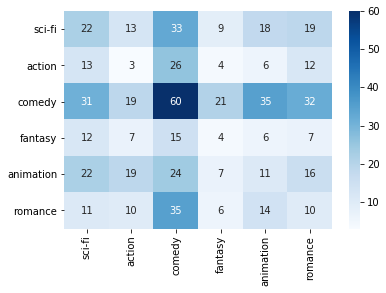

DummyClassifier1 : 0.179738562091503272


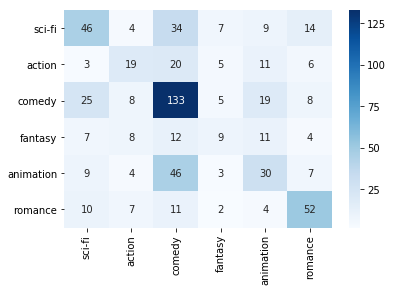

RidgeClassifier1 : 0.47222222222222222


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


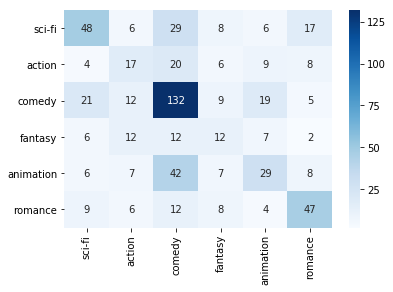

SGDClassifier1 : 0.465686274509803932


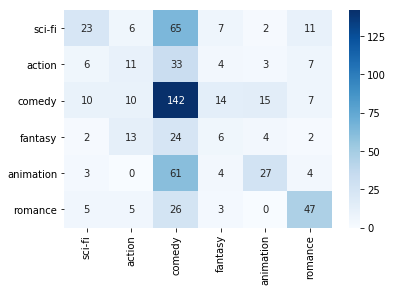

AdaBoostClassifier1 : 0.418300653594771252


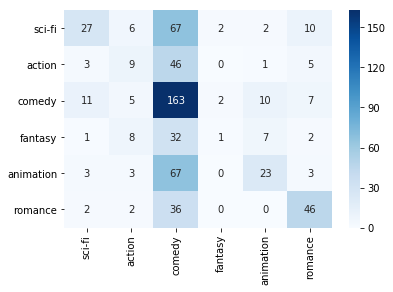

GradientBoostingClassifier1 : 0.43954248366013072


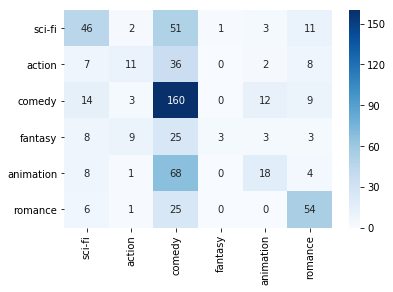

RandomForestClassifier1 : 0.4771241830065362


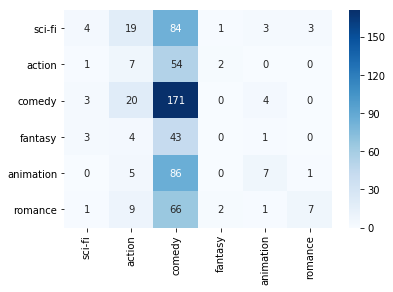

KNeighborsClassifier1 : 0.32026143790849672


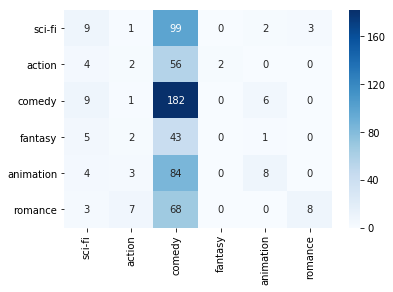

KNeighborsClassifier1 : 0.34150326797385622


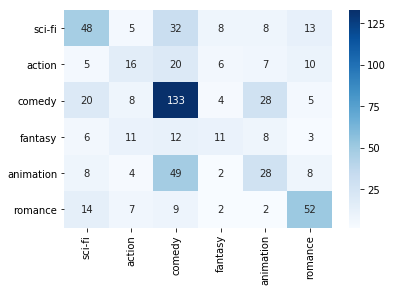

LogisticRegression1 : 0.470588235294117642


In [97]:
results = [examine(clf, bag_of_words_train, bag_of_words_test, train['tag'], test['tag']) for clf in classifiers()]

In [98]:
print_results(results)

DummyClassifier: 0.17973856209150327
KNeighborsClassifier: 0.3202614379084967
KNeighborsClassifier: 0.3415032679738562
AdaBoostClassifier: 0.41830065359477125
GradientBoostingClassifier: 0.4395424836601307
SGDClassifier: 0.46568627450980393
LogisticRegression: 0.47058823529411764
RidgeClassifier: 0.4722222222222222
RandomForestClassifier: 0.477124183006536


Лучшая модель 0.477 ~ 0.472. Получили улучшение на 0.01. немного..

# Tf-IDF

$$\mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

$$\mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$$\operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(tokenizer=tokenize_text)
bag_of_words_train = cv.fit_transform(train['plot'])
bag_of_words_test = cv.transform(test['plot'])

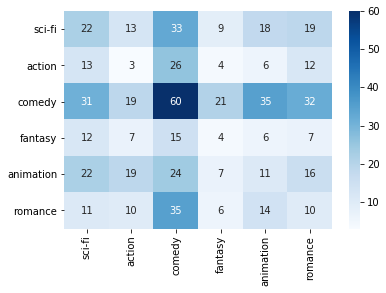

DummyClassifier1 : 0.179738562091503272


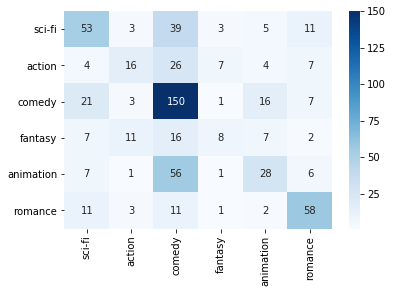

RidgeClassifier1 : 0.5114379084967322


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


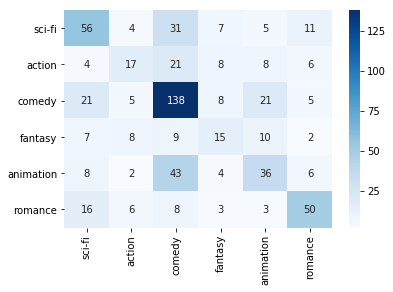

SGDClassifier1 : 0.50980392156862742


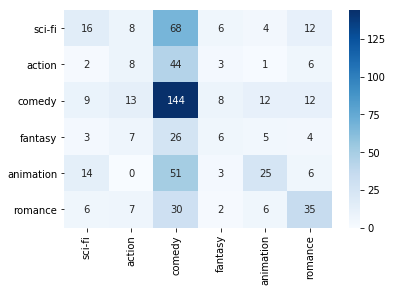

AdaBoostClassifier1 : 0.382352941176470562


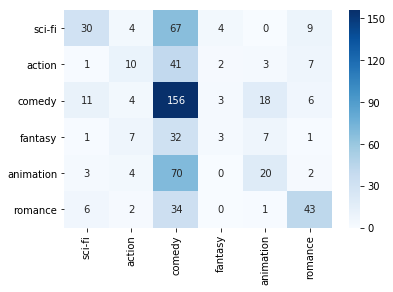

GradientBoostingClassifier1 : 0.428104575163398672


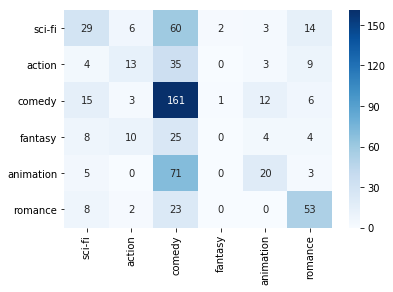

RandomForestClassifier1 : 0.450980392156862752


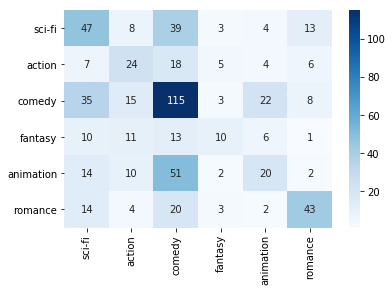

KNeighborsClassifier1 : 0.423202614379084962


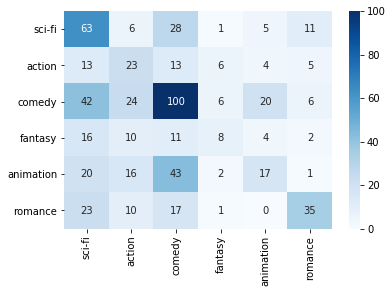

KNeighborsClassifier1 : 0.40196078431372552


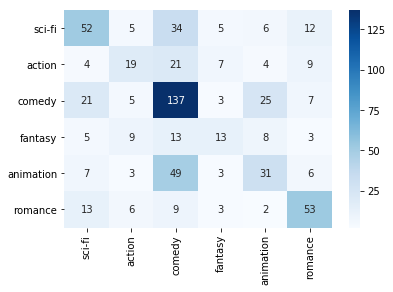

LogisticRegression1 : 0.498366013071895432


In [100]:
results = [examine(clf, bag_of_words_train, bag_of_words_test, train['tag'], test['tag']) for clf in classifiers()]

In [101]:
print_results(results)

DummyClassifier: 0.17973856209150327
AdaBoostClassifier: 0.38235294117647056
KNeighborsClassifier: 0.4019607843137255
KNeighborsClassifier: 0.42320261437908496
GradientBoostingClassifier: 0.42810457516339867
RandomForestClassifier: 0.45098039215686275
LogisticRegression: 0.49836601307189543
SGDClassifier: 0.5098039215686274
RidgeClassifier: 0.511437908496732


Получили значимое улучшение! Теперь качество 0.511, причем вперед вырвалась линейная модель, а не случайный лес. Загадочно.

In [102]:
clf = RidgeClassifier(random_state=42)
clf.fit(bag_of_words_train, train['tag'])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=42, solver='auto',
        tol=0.001)

In [103]:
most_influential_words(clf, cv, genre_name='action', num_words=10)

['terrorist',
 'agent',
 'frank',
 'assassin',
 'armi',
 'martial',
 'oper',
 'art',
 'cia',
 'poison']

In [104]:
most_influential_words(clf, cv, genre_name='romance', num_words=10)

['love',
 'fall',
 'affair',
 'romant',
 'danc',
 'marri',
 'decad',
 'aristocrat',
 'romanc',
 'possess']

In [105]:
most_influential_words(clf, cv, genre_name='animation', num_words=10)

['anim',
 'forest',
 'adventur',
 'name',
 'hero',
 'halloween',
 'princ',
 'bird',
 'dinosaur',
 'blu']

In [106]:
most_influential_words(clf, cv, genre_name='fantasy', num_words=10)

['kingdom',
 'magic',
 'harri',
 'queen',
 'hogwart',
 'god',
 'world',
 'tom',
 'dragon',
 'louie']

In [108]:
most_influential_words(clf, cv, genre_name='sci-fi', num_words=10)

['futur',
 'human',
 'alien',
 'space',
 'earth',
 'futurist',
 'planet',
 'engin',
 'experi',
 'war']

# Word2Vec

In [110]:
%%time
import gensim
tokenized_texts = train['plot'].apply(tokenize_text)
wv = gensim.models.Word2Vec(tokenized_texts, size=200, min_count=2)  # создаем wv модель и тренируем ее

CPU times: user 38.4 s, sys: 6.75 s, total: 45.1 s
Wall time: 49.7 s


In [111]:
wv.init_sims()

Отлично, мы умеем генерировать распределенные вектора размерности 200. Но в предложении у нас много слов, что с ними делать? Самое простое решение - это найти средний вектор предложения. Предполагая, что в нем будет основная идея предложения. Про это можно посмотреть [видео](https://www.youtube.com/watch?v=7gTjYwiaJiU).

![](https://github.com/RaRe-Technologies/movie-plots-by-genre/raw/e40face3a75e401223a100a057361f4cee2fd57a/ipynb_with_output/images/naivedoc2vec.png)

In [136]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    layer_size = wv.vector_size
    wv=wv.wv
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        return np.zeros(layer_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [113]:
%%time
X_train_word_average = word_averaging_list(wv, train['plot'].apply(tokenize_text))
X_test_word_average = word_averaging_list(wv, test['plot'].apply(tokenize_text))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if __name__ == '__main__':


CPU times: user 1min, sys: 11.8 s, total: 1min 12s
Wall time: 1min 27s


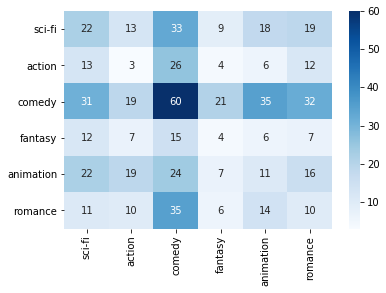

DummyClassifier1 : 0.179738562091503272


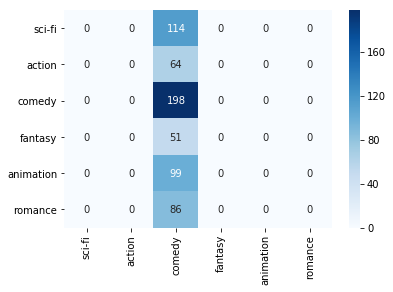

RidgeClassifier1 : 0.32352941176470592


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


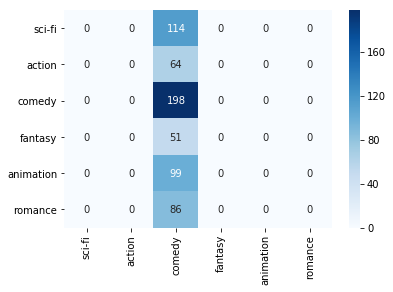

SGDClassifier1 : 0.32352941176470592


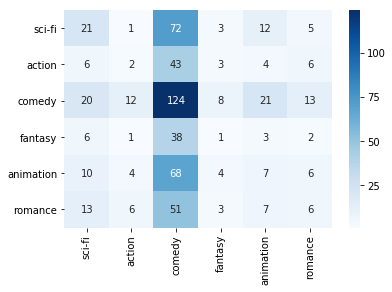

AdaBoostClassifier1 : 0.26307189542483662


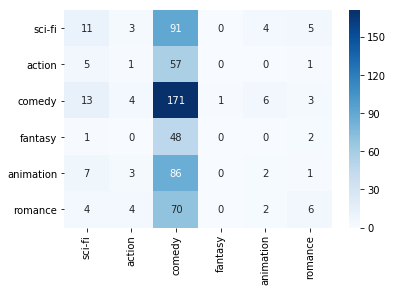

GradientBoostingClassifier1 : 0.312091503267973862


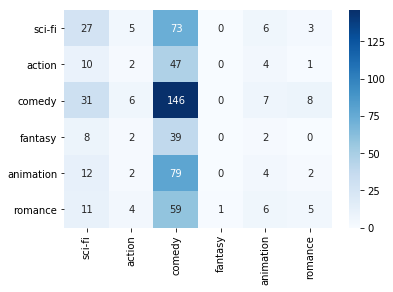

RandomForestClassifier1 : 0.30065359477124182


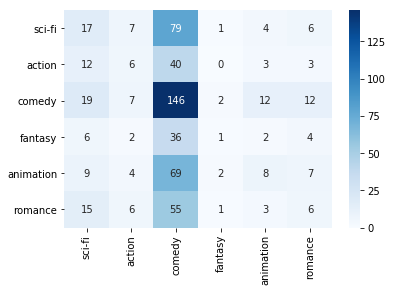

KNeighborsClassifier1 : 0.30065359477124182


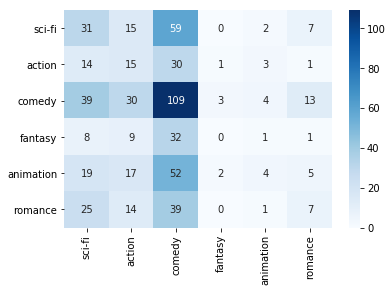

KNeighborsClassifier1 : 0.271241830065359462


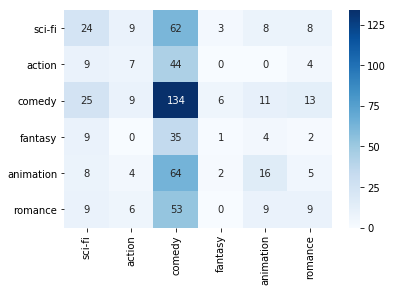

LogisticRegression1 : 0.312091503267973862


In [114]:
results = [examine(clf, X_train_word_average, X_test_word_average, train['tag'], test['tag']) for clf in classifiers()]

Логично, что всё стало хуже, так как мы обучали свой word2vec на очень маленьком датасете.

In [163]:
txt = test['plot'].reset_index().drop(['index'], axis=1).values

In [ ]:
i = 1
print(txt[i][0])
wv.most_similar(positive=[X_test_word_average[i]], restrict_vocab=100000, topn=30)[0:20]

# Pretrained Word2Vec

Загружаем натренированный на новостях в Google word2vec: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

Это может занять много времени. На MacBook PRO 2012 это заняло 4 минуты. В памяти занимать будет около 7GB.

In [119]:
%%time
import gensim
wv = gensim.models.KeyedVectors.load_word2vec_format(
    "data/GoogleNews-vectors-negative300.bin.gz",
    binary=True)

CPU times: user 3min 49s, sys: 8.1 s, total: 3min 58s
Wall time: 4min 20s


In [120]:
wv.init_sims()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if __name__ == '__main__':


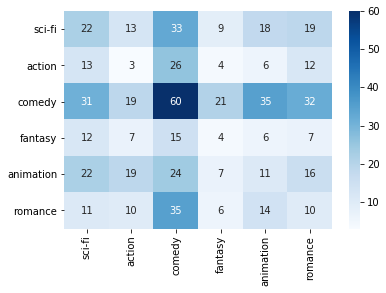

DummyClassifier1 : 0.179738562091503272


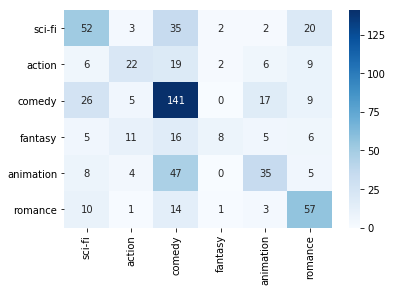

RidgeClassifier1 : 0.51470588235294112


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


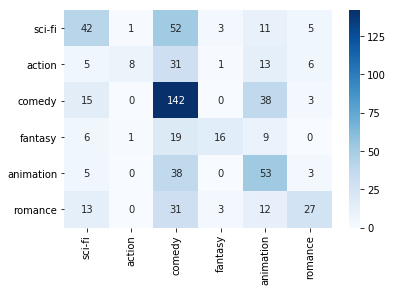

SGDClassifier1 : 0.470588235294117642


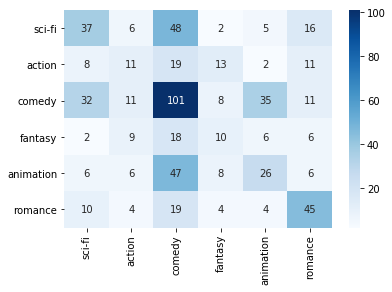

AdaBoostClassifier1 : 0.37581699346405232


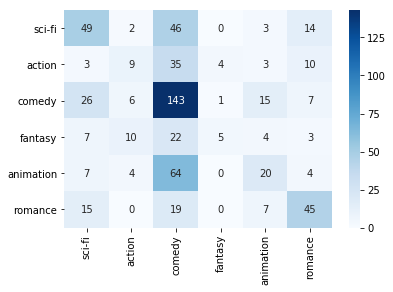

GradientBoostingClassifier1 : 0.442810457516339852


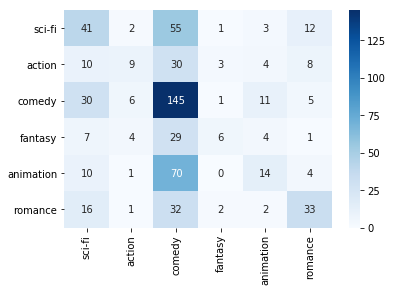

RandomForestClassifier1 : 0.405228758169934642


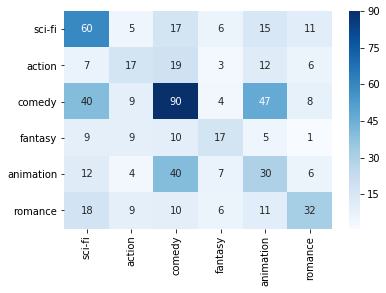

KNeighborsClassifier1 : 0.40196078431372552


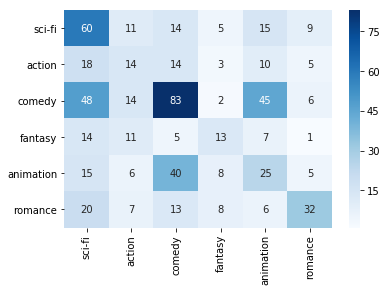

KNeighborsClassifier1 : 0.37091503267973862


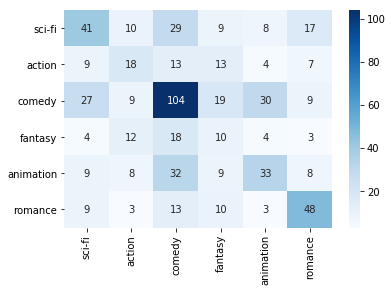

LogisticRegression1 : 0.41503267973856212
CPU times: user 1min 10s, sys: 8.55 s, total: 1min 18s
Wall time: 1min 24s


In [137]:
%%time
X_train_word_average = word_averaging_list(wv, train['plot'].apply(tokenize_text))
X_test_word_average = word_averaging_list(wv, test['plot'].apply(tokenize_text))
results = [examine(clf, X_train_word_average, X_test_word_average, train['tag'], test['tag']) for clf in classifiers()]

In [138]:
print_results(results)

DummyClassifier: 0.17973856209150327
KNeighborsClassifier: 0.3709150326797386
AdaBoostClassifier: 0.3758169934640523
KNeighborsClassifier: 0.4019607843137255
RandomForestClassifier: 0.40522875816993464
LogisticRegression: 0.4150326797385621
GradientBoostingClassifier: 0.44281045751633985
SGDClassifier: 0.47058823529411764
RidgeClassifier: 0.5147058823529411


In [160]:
txt = test['plot'].reset_index().drop(['index'], axis=1).values

In [162]:
i = 1
print(txt[i][0])
wv.most_similar(positive=[X_test_word_average[i]], restrict_vocab=100000, topn=30)[0:20]

The film follows a girl named Sintel who is searching for a baby dragon she calls Scales. A flashback reveals that Sintel found Scales with its wing injured and helped care for it, forming a close bond with it. By the time its wing recovered and it was able to fly, Scales was caught by an adult dragon. Sintel has since embarked on a quest to rescue Scales, fending off beasts and warriors along the way. She eventually comes across a cave housing an adult and baby dragon, the latter of which she believes to be Scales. The adult dragon discovers and attacks Sintel, but hesitates to kill her. Sintel slays the dragon, only to recognize the scar on its wing and realize the dragon is an adult Scales, and that she too has aged considerably. Sintel leaves the cave heartbroken, unknowingly followed by Scales's baby.


[('dragon', 0.5586178302764893),
 ('By_Anonymous_##-##-##', 0.47224196791648865),
 ('creature', 0.47217708826065063),
 ('For_Restrictions', 0.47158560156822205),
 ('dragons', 0.4709089398384094),
 ('fairy', 0.4678560495376587),
 ('monkey', 0.4604794681072235),
 ('ape', 0.45740807056427),
 ('beast', 0.4570545256137848),
 ('By_TBT_staff', 0.4549024701118469),
 ('lizard', 0.4548420310020447),
 ('You_EIG', 0.4543105959892273),
 ('RBC_##.##.####_Moscow', 0.45301392674446106),
 ('scale', 0.44673699140548706),
 ('beasts', 0.44618818163871765),
 ('slay', 0.4456084370613098),
 ('monsters', 0.4433647692203522),
 ('monster', 0.4375864863395691),
 ('serpent', 0.43267822265625),
 ('just', 0.43126899003982544)]

In [165]:
i = 42
print(txt[i][0])
wv.most_similar(positive=[X_test_word_average[i]], restrict_vocab=100000, topn=30)[0:20]

A living puppet, with the help of a cricket as his conscience, must prove himself worthy to become a real boy.


[('real', 0.5318611860275269),
 ('do', 0.5118840932846069),
 ('can', 0.5073270201683044),
 ('want', 0.5058157444000244),
 ('live', 0.5034912824630737),
 ('must', 0.4994562864303589),
 ('pretend', 0.4962177872657776),
 ('prove', 0.47637271881103516),
 ('know', 0.45864230394363403),
 ('truly', 0.45702463388442993),
 ('help', 0.4568851590156555),
 ('need', 0.4560326337814331),
 ('not', 0.45195329189300537),
 ('if', 0.44674935936927795),
 ('so', 0.44143736362457275),
 ('always', 0.43911585211753845),
 ('cricket', 0.4380960464477539),
 ('just', 0.4286497235298157),
 ('whatever', 0.4274134039878845),
 ('hope', 0.42669644951820374)]

In [166]:
i = 13
print(txt[i][0])
wv.most_similar(positive=[X_test_word_average[i]], restrict_vocab=100000, topn=30)[0:20]

Frank Drebin comes out of retirement to help Police Squad infiltrate a gang of terrorists planning to detonate a bomb at the Academy Awards.


[('terrorist', 0.5296939611434937),
 ('bomb', 0.5221438407897949),
 ('gang', 0.5124354362487793),
 ('terror', 0.490788996219635),
 ('terrorists', 0.4652043581008911),
 ('squad', 0.45710715651512146),
 ('come', 0.45398035645484924),
 ('terrorism', 0.45025306940078735),
 ('bombs', 0.4311904013156891),
 ('militant', 0.4294081926345825),
 ('al_Qaeda', 0.4281303882598877),
 ('kidnap', 0.4213046431541443),
 ('al_Qaida', 0.4201825261116028),
 ('counter_terrorism', 0.4186362326145172),
 ('Al_Qaeda', 0.41718214750289917),
 ('gangs', 0.41369718313217163),
 ('LeT', 0.41238167881965637),
 ('help', 0.4087580144405365),
 ('extremist', 0.4044364094734192),
 ('team', 0.40184417366981506)]

# Doc2Vec 
Paragraph Vectors Doc2Vec

Можно почитать эту статью. В ней говорят о том, что добавляют еще такое понятие как тег в модель.
https://cs.stanford.edu/~quocle/paragraph_vector.pdf

In [167]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [168]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r['tag']]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r['tag']]), axis=1)

In [176]:
test_tagged.values[42]

TaggedDocument(words=['live', 'puppet', 'help', 'cricket', 'conscienc', 'must', 'prove', 'worthi', 'becom', 'real', 'boy'], tags=['fantasy'])

In [177]:
test_tagged.values[36]

TaggedDocument(words=['phobic', 'con', 'artist', 'protg', 'verg', 'pull', 'lucr', 'swindl', 'former', "'s", 'teenag', 'daughter', 'arriv', 'unexpectedli'], tags=['comedy'])

In [192]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=2, size=5, iter=80, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

/usr/local/lib/python3.6/site-packages/gensim/models/doc2vec.py:362: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


CPU times: user 17.7 s, sys: 2.29 s, total: 20 s
Wall time: 14.9 s


In [193]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

CPU times: user 958 ms, sys: 14.5 ms, total: 972 ms
Wall time: 1.2 s


In [194]:
import itertools
# convert from tuple to array
train_targets = [x for x in train_targets]
test_targets = [x for x in test_targets]

train_regressors = np.array([x for x in train_regressors])
test_regressors = np.array([x for x in test_regressors])

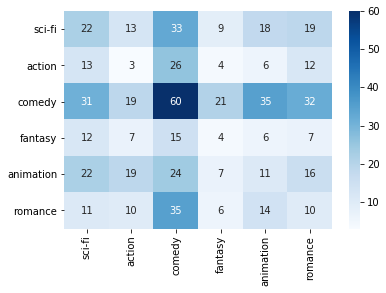

DummyClassifier1 : 0.179738562091503272


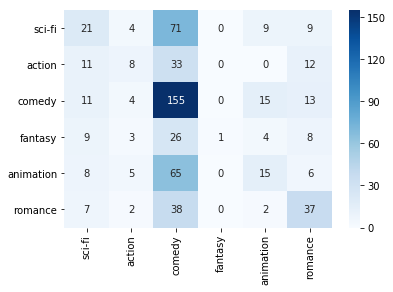

RidgeClassifier1 : 0.38725490196078432


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


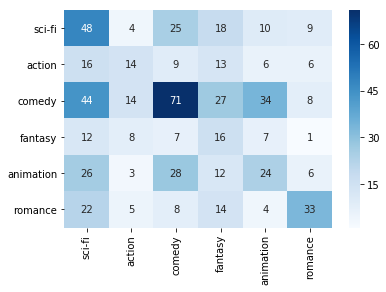

SGDClassifier1 : 0.33660130718954252


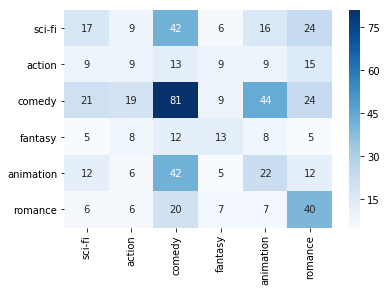

AdaBoostClassifier1 : 0.29738562091503272


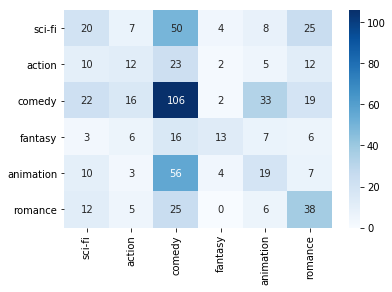

GradientBoostingClassifier1 : 0.339869281045751652


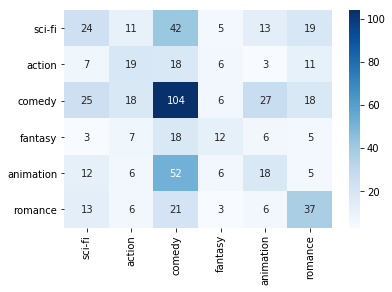

RandomForestClassifier1 : 0.349673202614379062


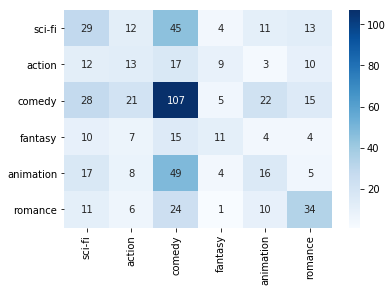

KNeighborsClassifier1 : 0.34313725490196082


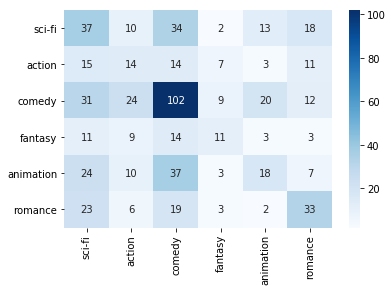

KNeighborsClassifier1 : 0.351307189542483632


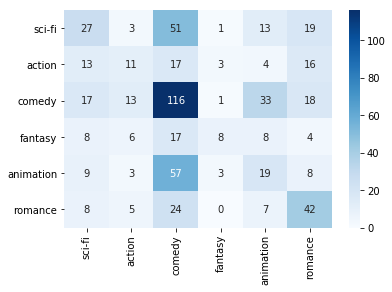

LogisticRegression1 : 0.364379084967320242


In [195]:
results = [examine(clf, train_regressors, test_regressors, train_targets, test_targets) for clf in classifiers()]

In [196]:
print_results(results)

DummyClassifier: 0.17973856209150327
AdaBoostClassifier: 0.2973856209150327
SGDClassifier: 0.3366013071895425
GradientBoostingClassifier: 0.33986928104575165
KNeighborsClassifier: 0.3431372549019608
RandomForestClassifier: 0.34967320261437906
KNeighborsClassifier: 0.35130718954248363
LogisticRegression: 0.36437908496732024
RidgeClassifier: 0.3872549019607843


In [197]:
doc2vec_model.docvecs.most_similar('action')

[('romance', 0.2890760600566864),
 ('sci-fi', 0.17232033610343933),
 ('fantasy', 0.13549959659576416),
 ('comedy', 0.07057008147239685),
 ('animation', -0.08250048756599426)]

In [198]:
doc2vec_model.docvecs.most_similar('sci-fi')

[('romance', 0.1974751353263855),
 ('action', 0.17232032120227814),
 ('comedy', 0.05878238379955292),
 ('fantasy', -0.0959462821483612),
 ('animation', -0.14434051513671875)]

In [199]:
doc2vec_model.most_similar([doc2vec_model.docvecs['sci-fi']])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('aircraft', 0.9701706767082214),
 ('satellit', 0.9699676632881165),
 ('bizarr', 0.969444215297699),
 ('area', 0.968100368976593),
 ('entir', 0.963672399520874),
 ('univers', 0.9622313976287842),
 ('fashion', 0.9610446691513062),
 ('left', 0.9584010243415833),
 ('base', 0.9541133046150208),
 ('machin', 0.9442561268806458)]

In [200]:
doc2vec_model.most_similar([doc2vec_model.docvecs['fantasy']])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ann', 0.9767142534255981),
 ('merlin', 0.9722006916999817),
 ('princess', 0.9674074649810791),
 ('cinderella', 0.9649550914764404),
 ('golden', 0.9625064730644226),
 ('imag', 0.9619238376617432),
 ('ogr', 0.960852861404419),
 ('immedi', 0.9579117298126221),
 ('princ', 0.9567705392837524),
 ('snow', 0.9526658058166504)]